# Keterangan Tugas

Film Junky Union, sebuah komunitas baru bagi penggemar film klasik sedang mengembangkan sistem untuk memfilter dan mengategorikan ulasan film. Misi utamanya adalah melatih model agar bisa mendeteksi ulasan negatif secara otomatis. Anda akan menggunakan *dataset* ulasan film IMBD dengan pelabelan polaritas untuk membuat sebuah model yang bisa mengklasifikasikan ulasan positif dan negatif. Model ini setidaknya harus memiliki skor F1 sebesar 0,85.

## Inisialisasi

In [ ]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import re

from tqdm.auto import tqdm

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# baris berikutnya menyediakan grafik dengan kualitas yang lebih baik di layar HiDPI

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [ ]:
# ini untuk menggunakan progress_apply, baca lebih lanjut dihttps://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Memuat data

In [ ]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [ ]:
df_reviews.shape

(47331, 17)

In [ ]:
df_reviews.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx'],
      dtype='object')

In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [ ]:
df_reviews['ds_part'].unique()

array(['train', 'test'], dtype=object)

In [ ]:
df_reviews['ds_part'].value_counts()

train    23796
test     23535
Name: ds_part, dtype: int64

## EDA

Periksa jumlah film dan ulasan selama beberapa tahun.

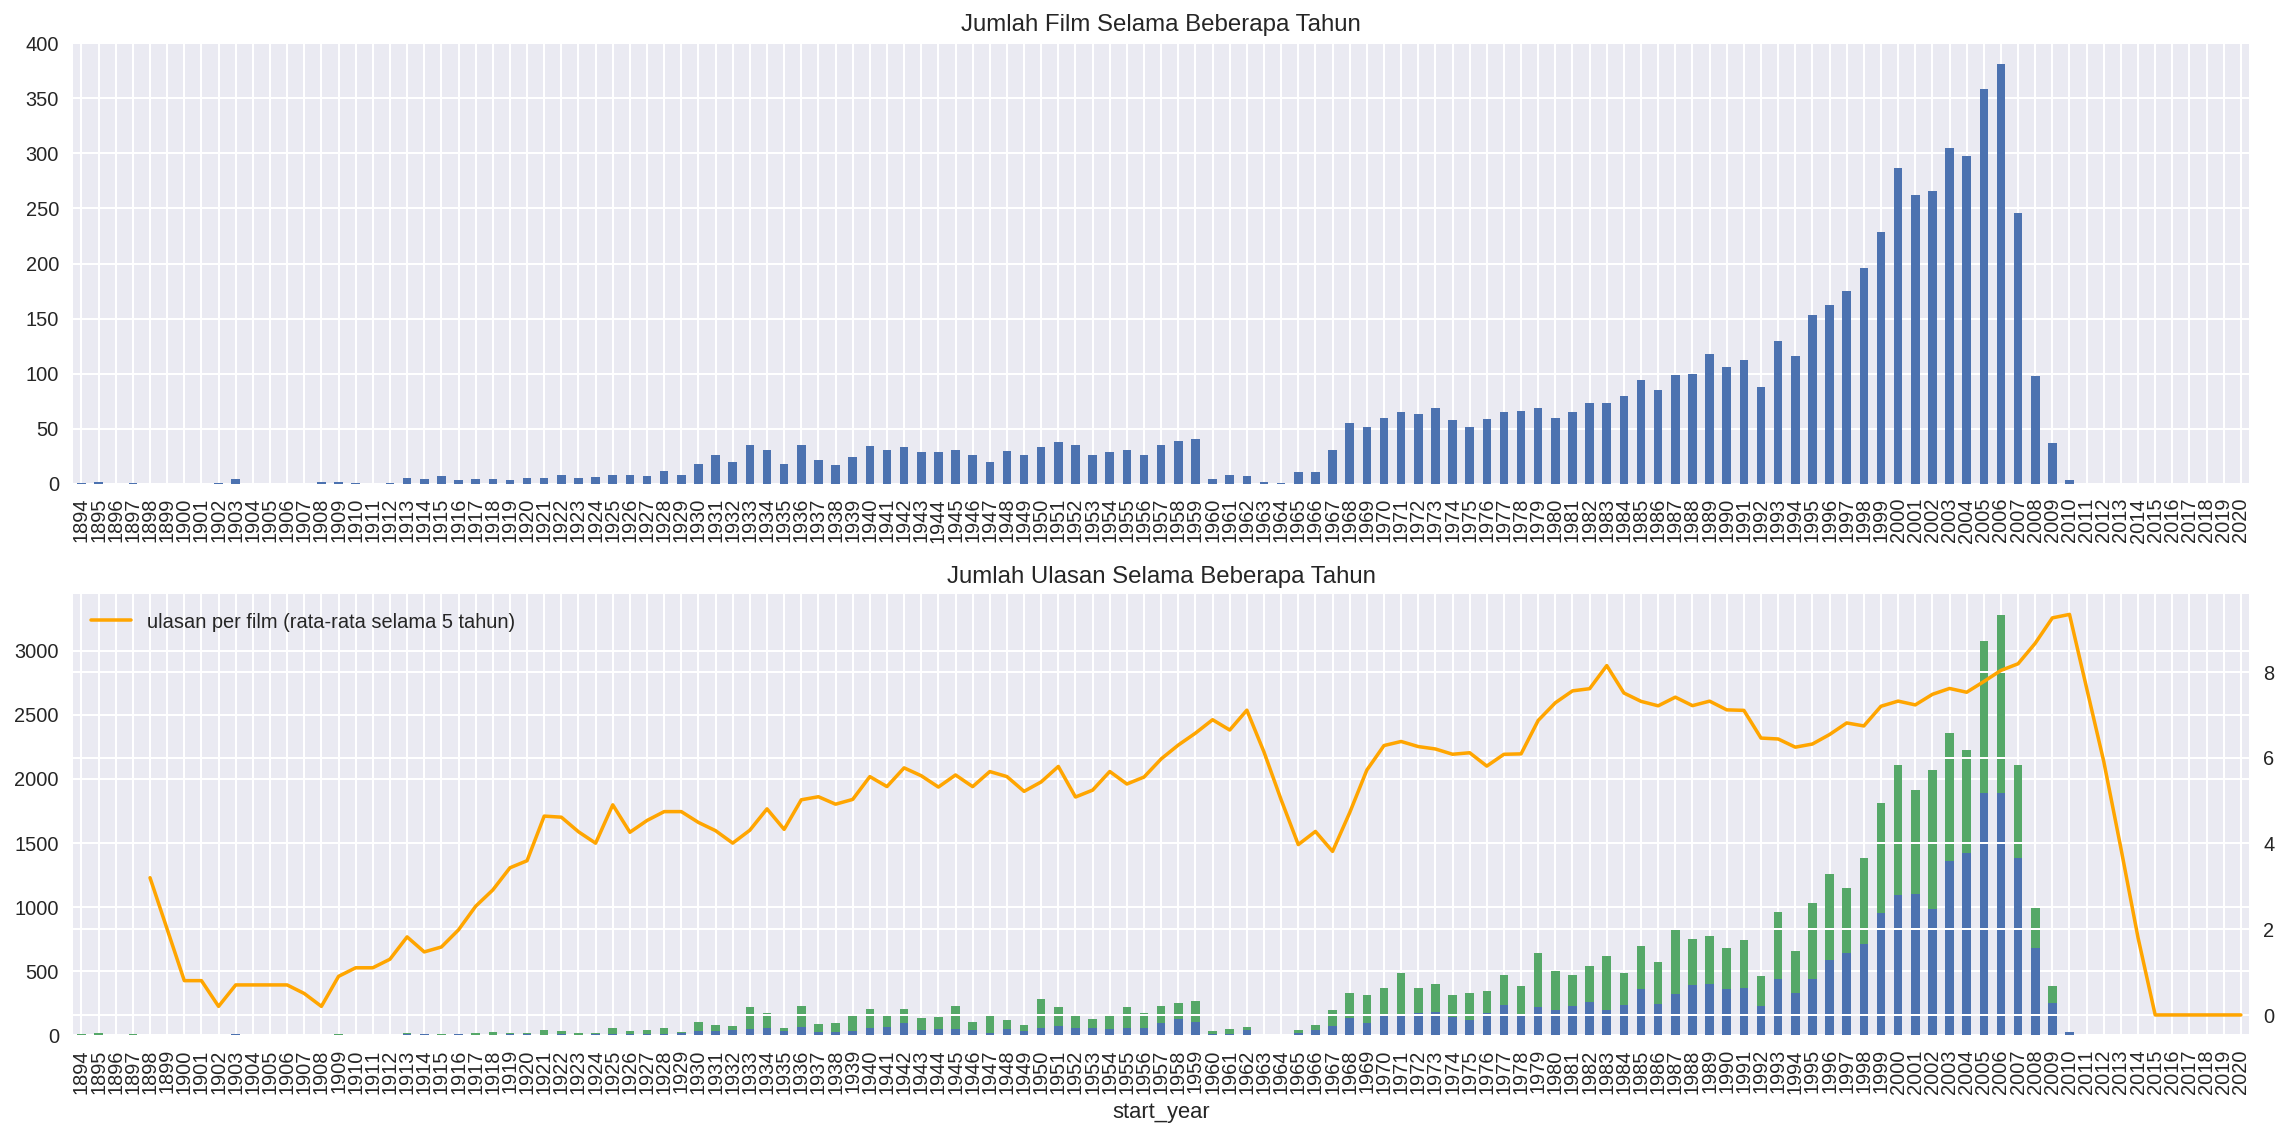

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Beberapa Tahun')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Jumlah Ulasan Selama Beberapa Tahun')

fig.tight_layout()

Periksa distribusi jumlah ulasan per film dengan penghitungan yang tepat dan KDE (hanya untuk mengetahui perbedaannya dari penghitungan yang tepat)

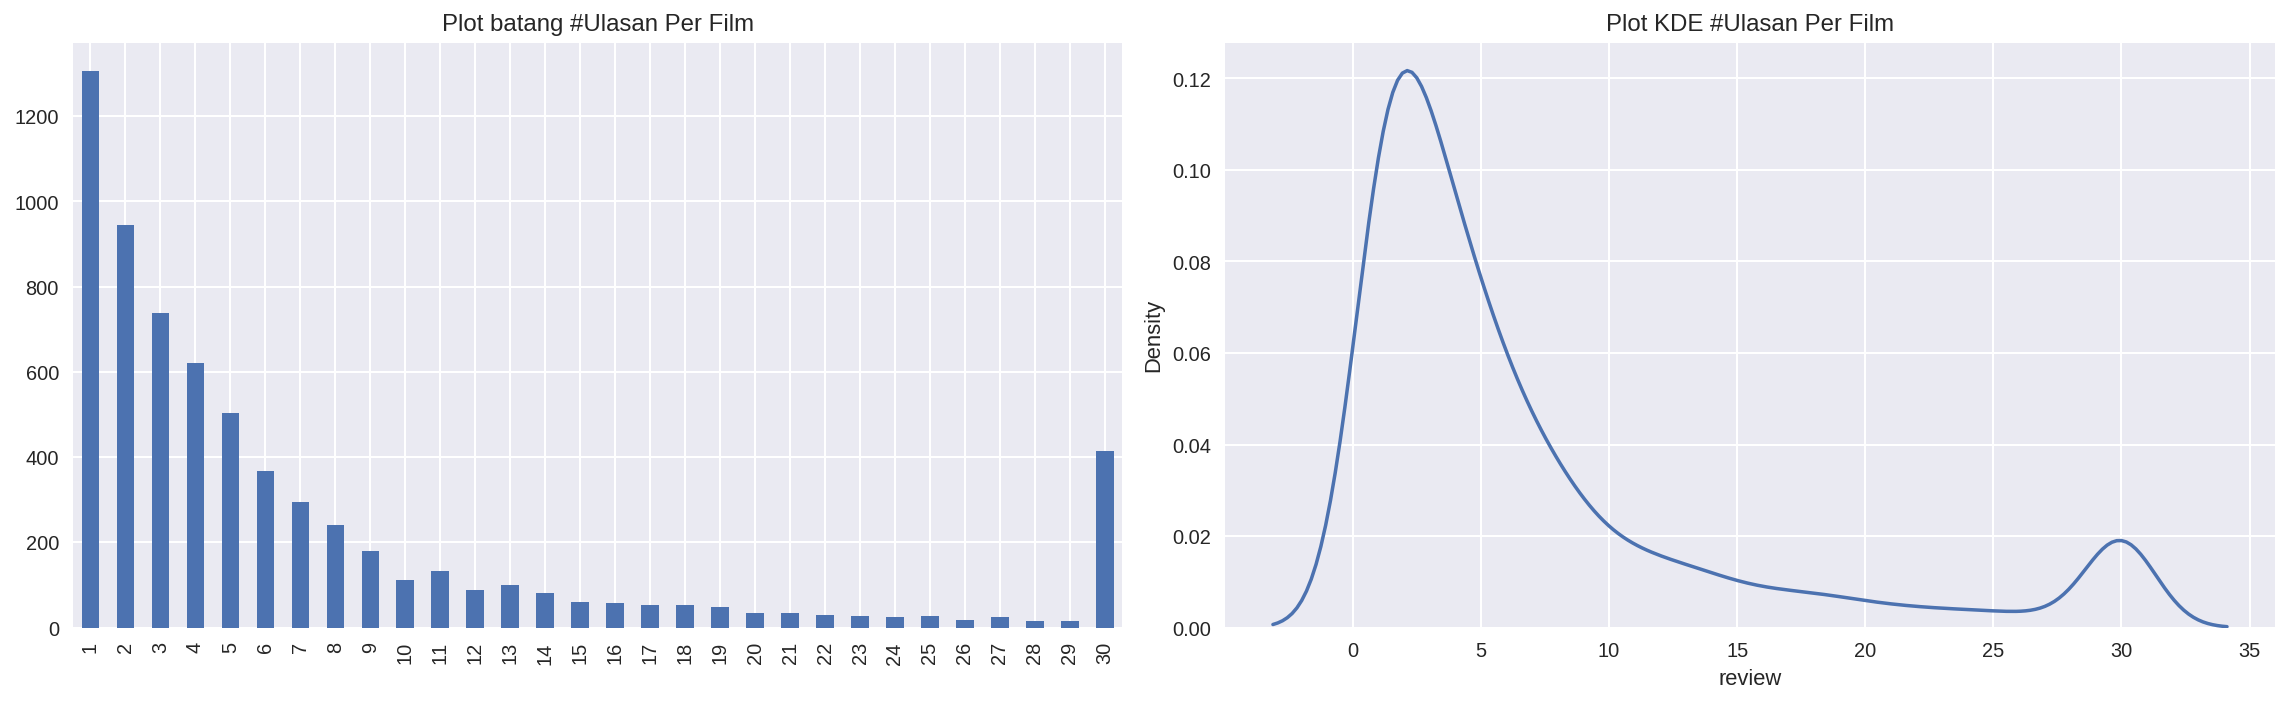

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film')

fig.tight_layout()

In [ ]:
df_reviews['ds_part'].value_counts()

train    23796
test     23535
Name: ds_part, dtype: int64

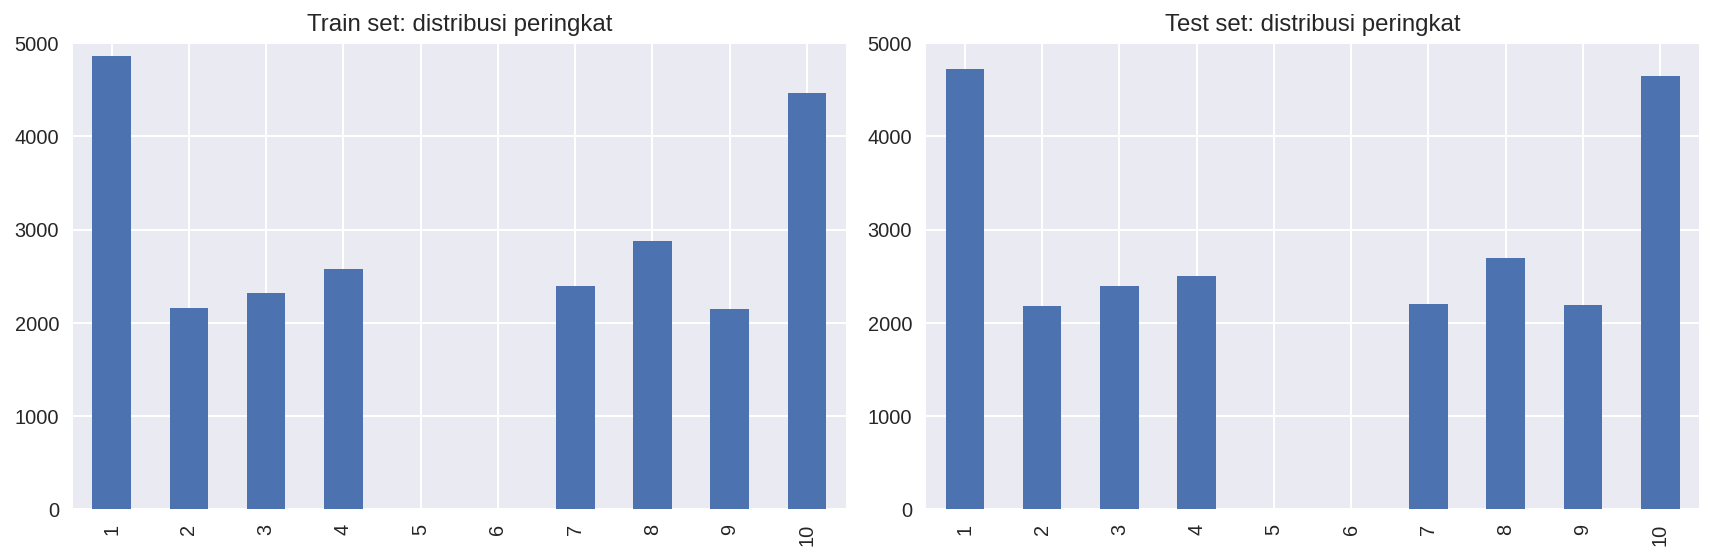

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: distribusi peringkat')

fig.tight_layout()

Distribusi ulasan negatif dan positif selama bertahun-tahun untuk dua bagian *dataset*

In [ ]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

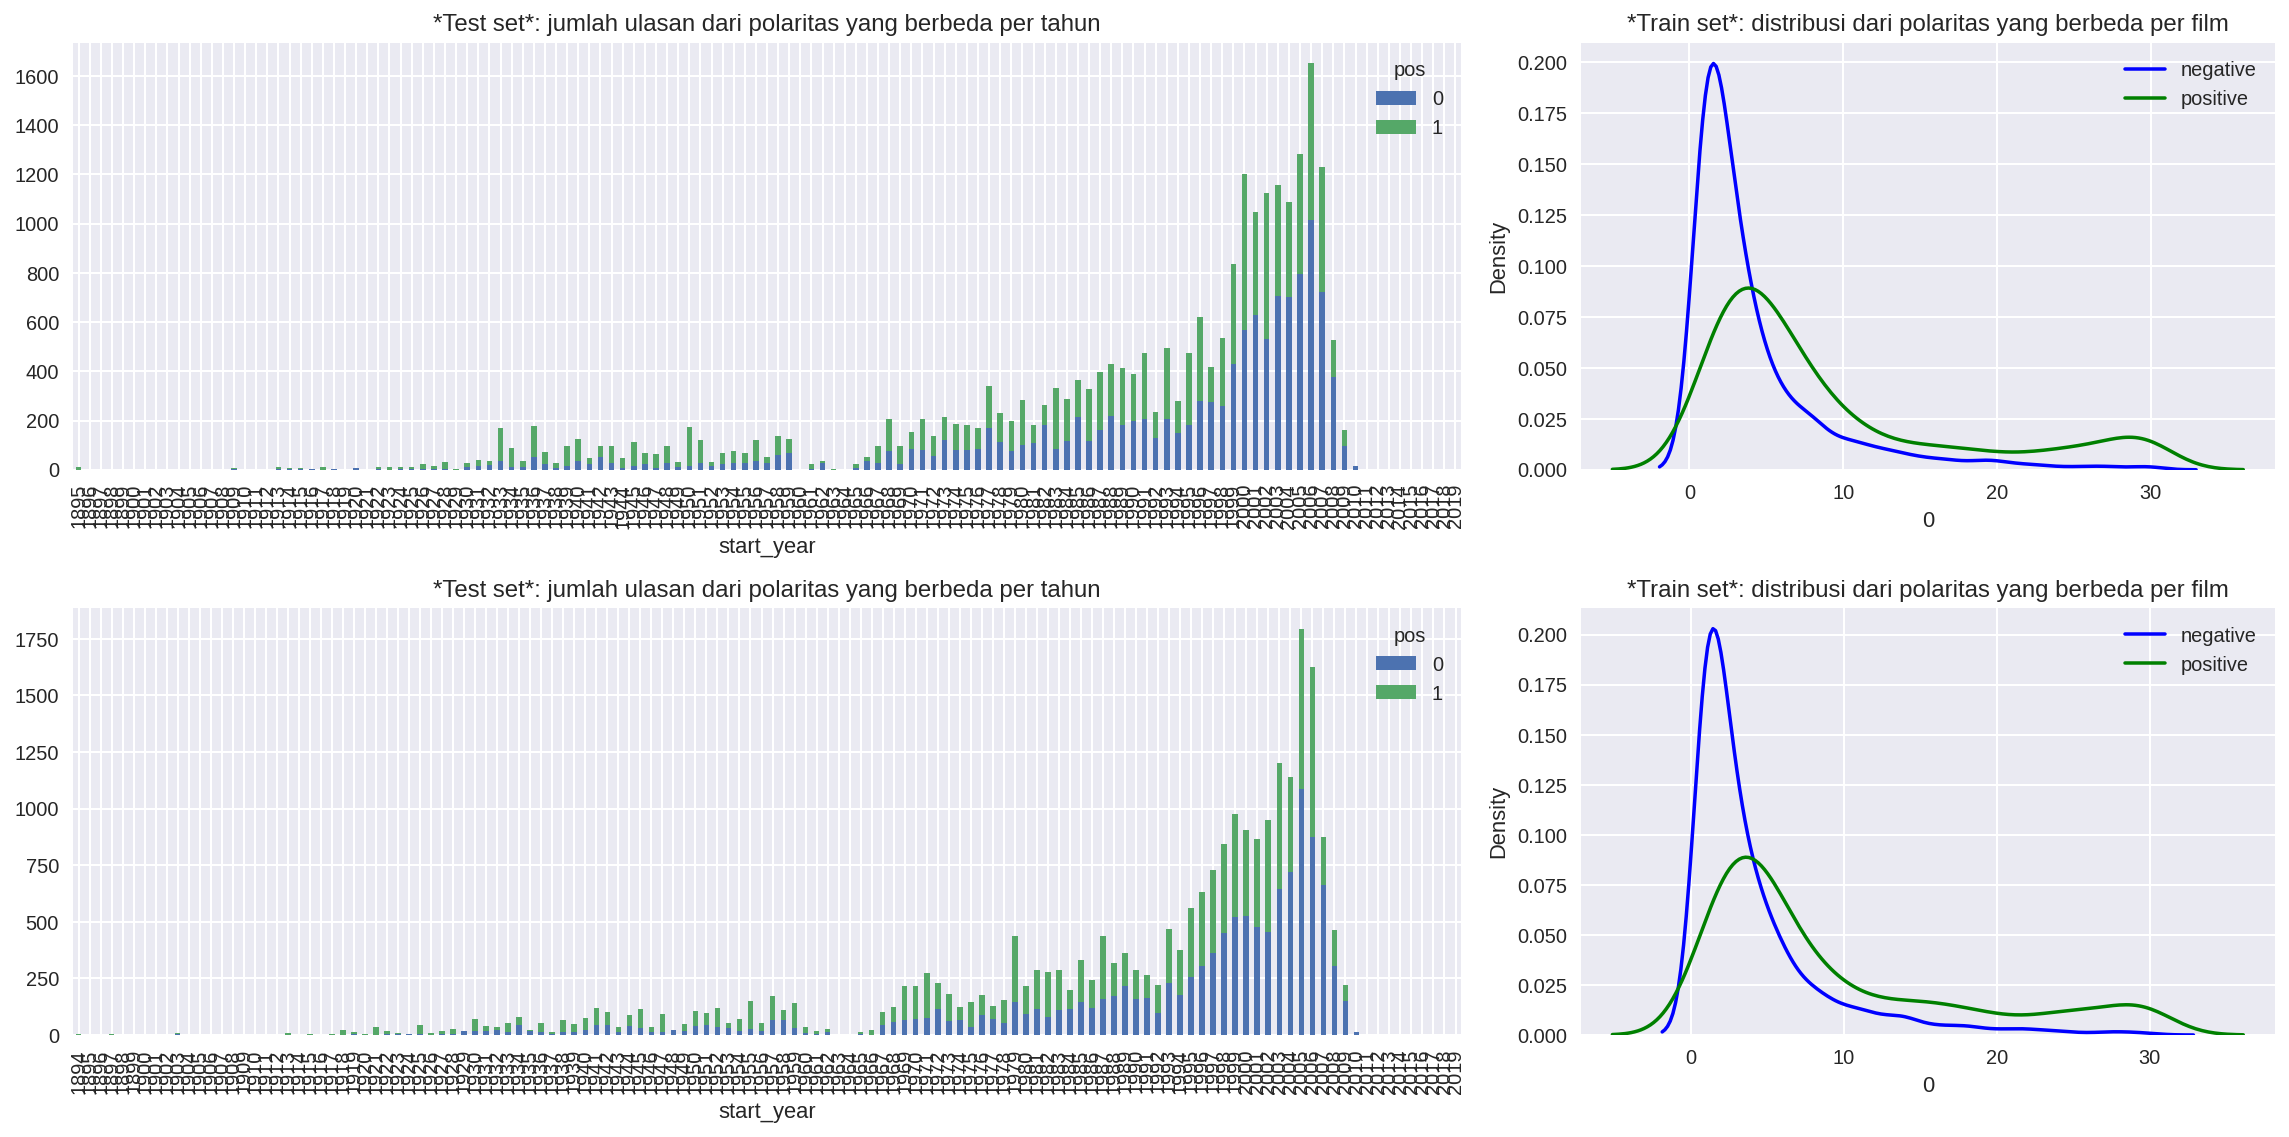

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribusi dari polaritas yang berbeda per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribusi dari polaritas yang berbeda per film')

fig.tight_layout()

## Prosedur Evaluasi

Menyusun evaluasi yang dapat digunakan untuk semua model dalam tugas ini secara rutin

In [ ]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Kurva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalisasi

Kita menganggap semua model di bawah menerima teks dalam huruf kecil dan tanpa angka, tanda baca, dll.

In [ ]:
def clear_text(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern,' ',text)
    text = text.split()
    text = " ".join(text).lower()
    return text

In [ ]:
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text) # < masukkan kode di sini >

In [ ]:
df_reviews['review_norm'].sample(1).array

<PandasArray>
["for the love of god please don't see this movie its a waste of time the plot is predictable as are the romantic scenes trying to build too much with very little this film and its evil predictable villain is just lame the characters aren't developed and most of the film is padded out with shots of rome which is much more interesting than the actual film to top all of that the acting is a disgrace i know everyone tries to find their niche but this is truly a disaster i can't believe that someone actually paid however many millions of pounds to put this film on screen don't waste money or time on this film go see your grandma or something worthwhile instead"]
Length: 1, dtype: object

## Pemisahan Train / Test

Untungnya, seluruh *dataset* sudah dibagi menjadi *train/test*. Bendera yang sesuai adalah 'ds_part'.

In [ ]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

x_train = df_reviews_train.drop(columns='pos')
x_test = df_reviews_test.drop(columns='pos')

print(x_train.shape)
print(x_test.shape)

(23796, 17)
(23535, 17)


In [ ]:
y_test.value_counts()

0    11803
1    11732
Name: pos, dtype: int64

In [ ]:
df_reviews_train.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx',
       'review_norm'],
      dtype='object')

## Bekerja dengan Model

### Model 0 - Konstan

In [ ]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


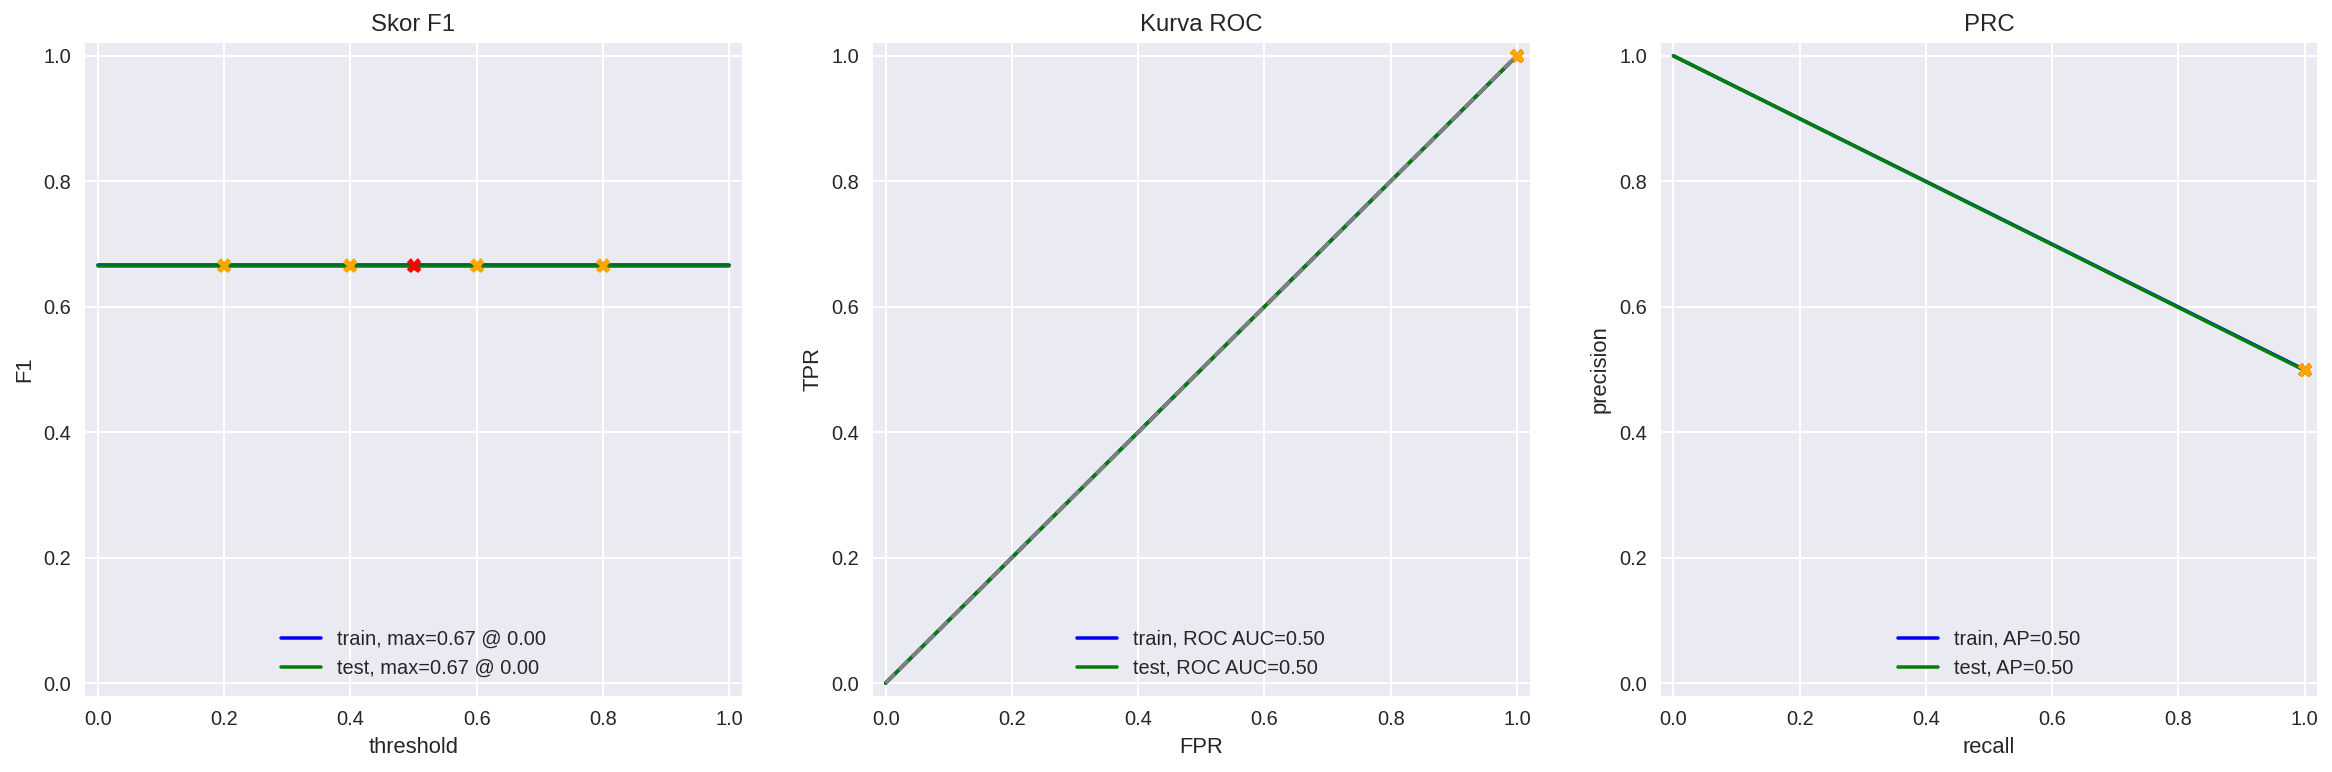

In [ ]:
model_dummy = DummyClassifier(strategy='constant', constant=1)
model_dummy.fit(x_train,y_train)

evaluate_model(model_dummy,x_train, y_train,x_test, y_test)

**Dari Model DummyClassifier di dapat bahwa dataset kita yang di bagi antara data train dan data test, Seimbang untuk target ulasan Negatif dan Positif**

### Model 1 - NLTK, TF-IDF dan LR

TF-IDF

In [ ]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')

train_tfidf = tfidf.fit_transform(x_train['review_norm'])

test_tfidf = tfidf.transform(x_test['review_norm'])

In [ ]:
print(train_tfidf.shape)
print(test_tfidf.shape)
print(train_targe.shape)

(23796, 71365)
(23535, 71365)


In [ ]:
model_LR = LogisticRegression()
model_LR.fit(train_tfidf, y_train)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


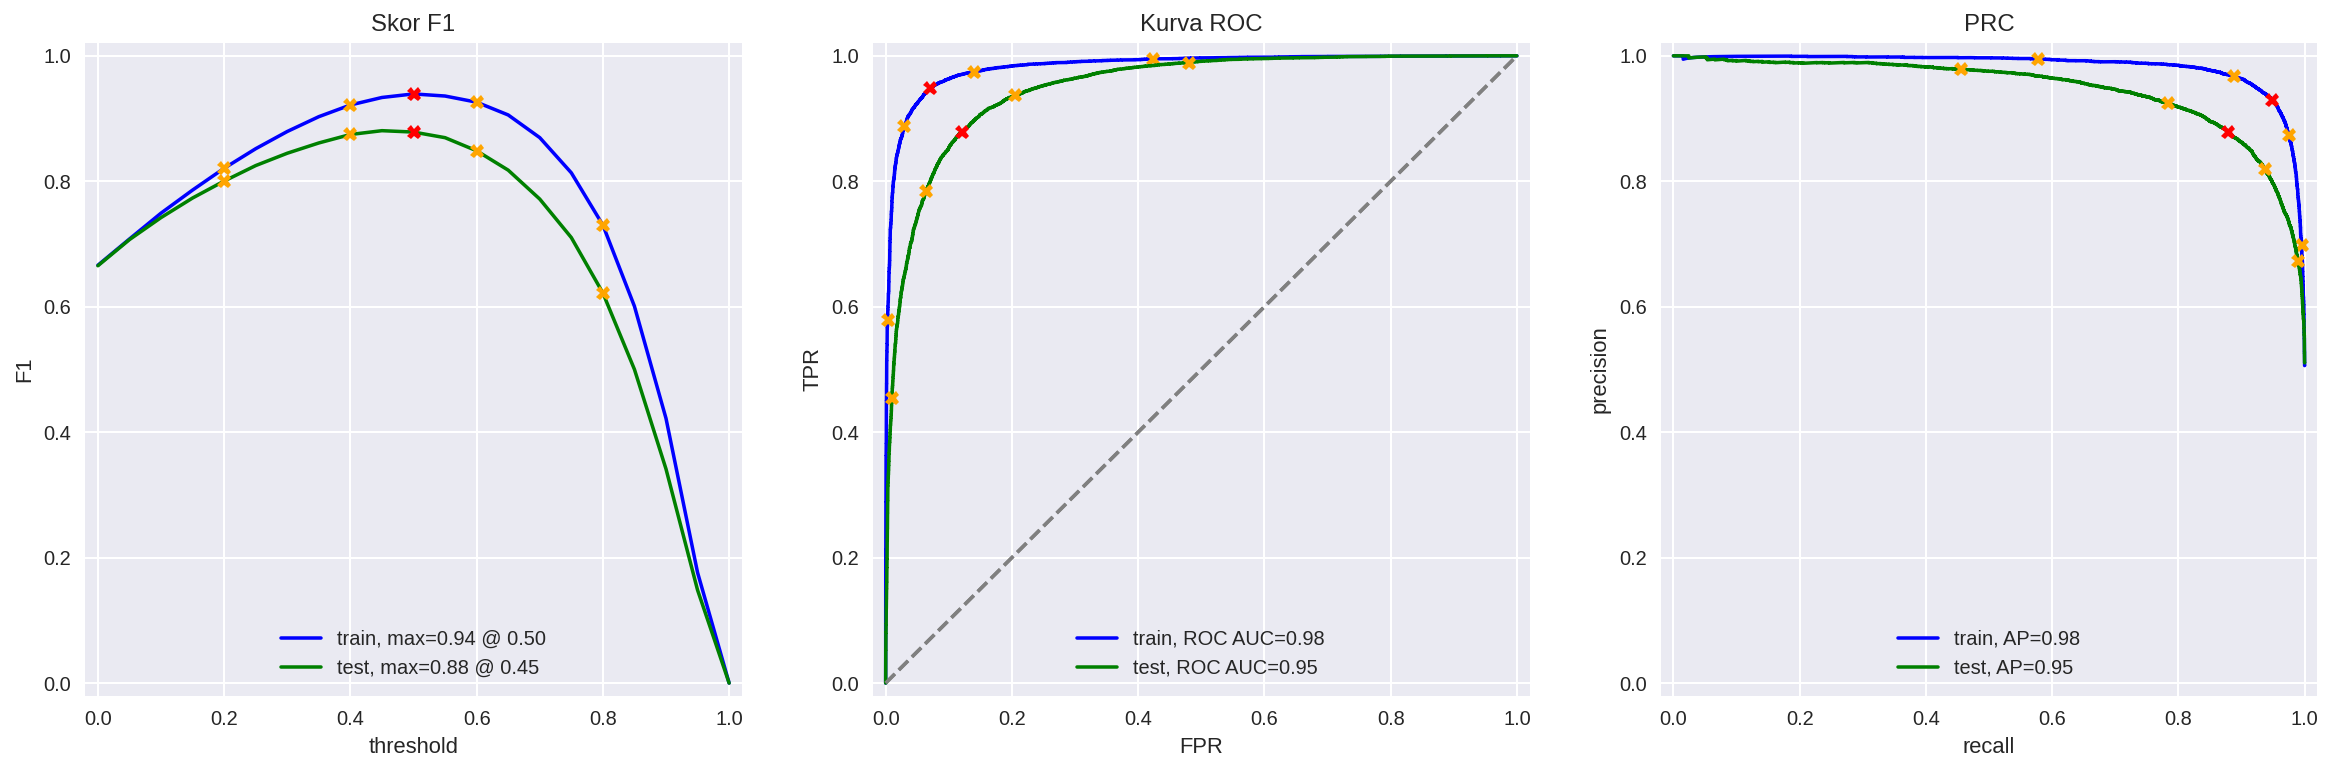

In [ ]:
evaluate_model(model_LR, train_tfidf, y_train, test_tfidf, y_test)

### Model 3 - spaCy, TF-IDF dan LR

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [ ]:
print(y_train[:10000].value_counts())
print(y_test[:10000].value_counts())

0    5101
1    4899
Name: pos, dtype: int64
0    5248
1    4752
Name: pos, dtype: int64


In [ ]:
%%time
lemma_train = x_train['review_norm'][:10000].apply(text_preprocessing_3)

CPU times: user 3min 24s, sys: 236 ms, total: 3min 25s
Wall time: 3min 25s


In [ ]:
%%time
lemma_test = x_test['review_norm'][:10000].apply(text_preprocessing_3)

CPU times: user 3min 26s, sys: 278 ms, total: 3min 26s
Wall time: 3min 27s


**Dikarenakan Proses Lemmatization yang sangat lama jika dilakukan dengan keseluruhan Datasets, maka saya hanya Ambil 10000 data saja dari data train maupun data test**

In [ ]:
tfidf1 = TfidfVectorizer(stop_words='english')

train_tfidf1 = tfidf1.fit_transform(lemma_train)

test_tfidf1 = tfidf1.transform(lemma_test)

In [ ]:
model_LR1 = LogisticRegression()
model_LR1.fit(train_tfidf1, y_train[:10000])

LogisticRegression()

          train  test
Accuracy   0.94  0.86
F1         0.94  0.85
APS        0.99  0.93
ROC AUC    0.98  0.93


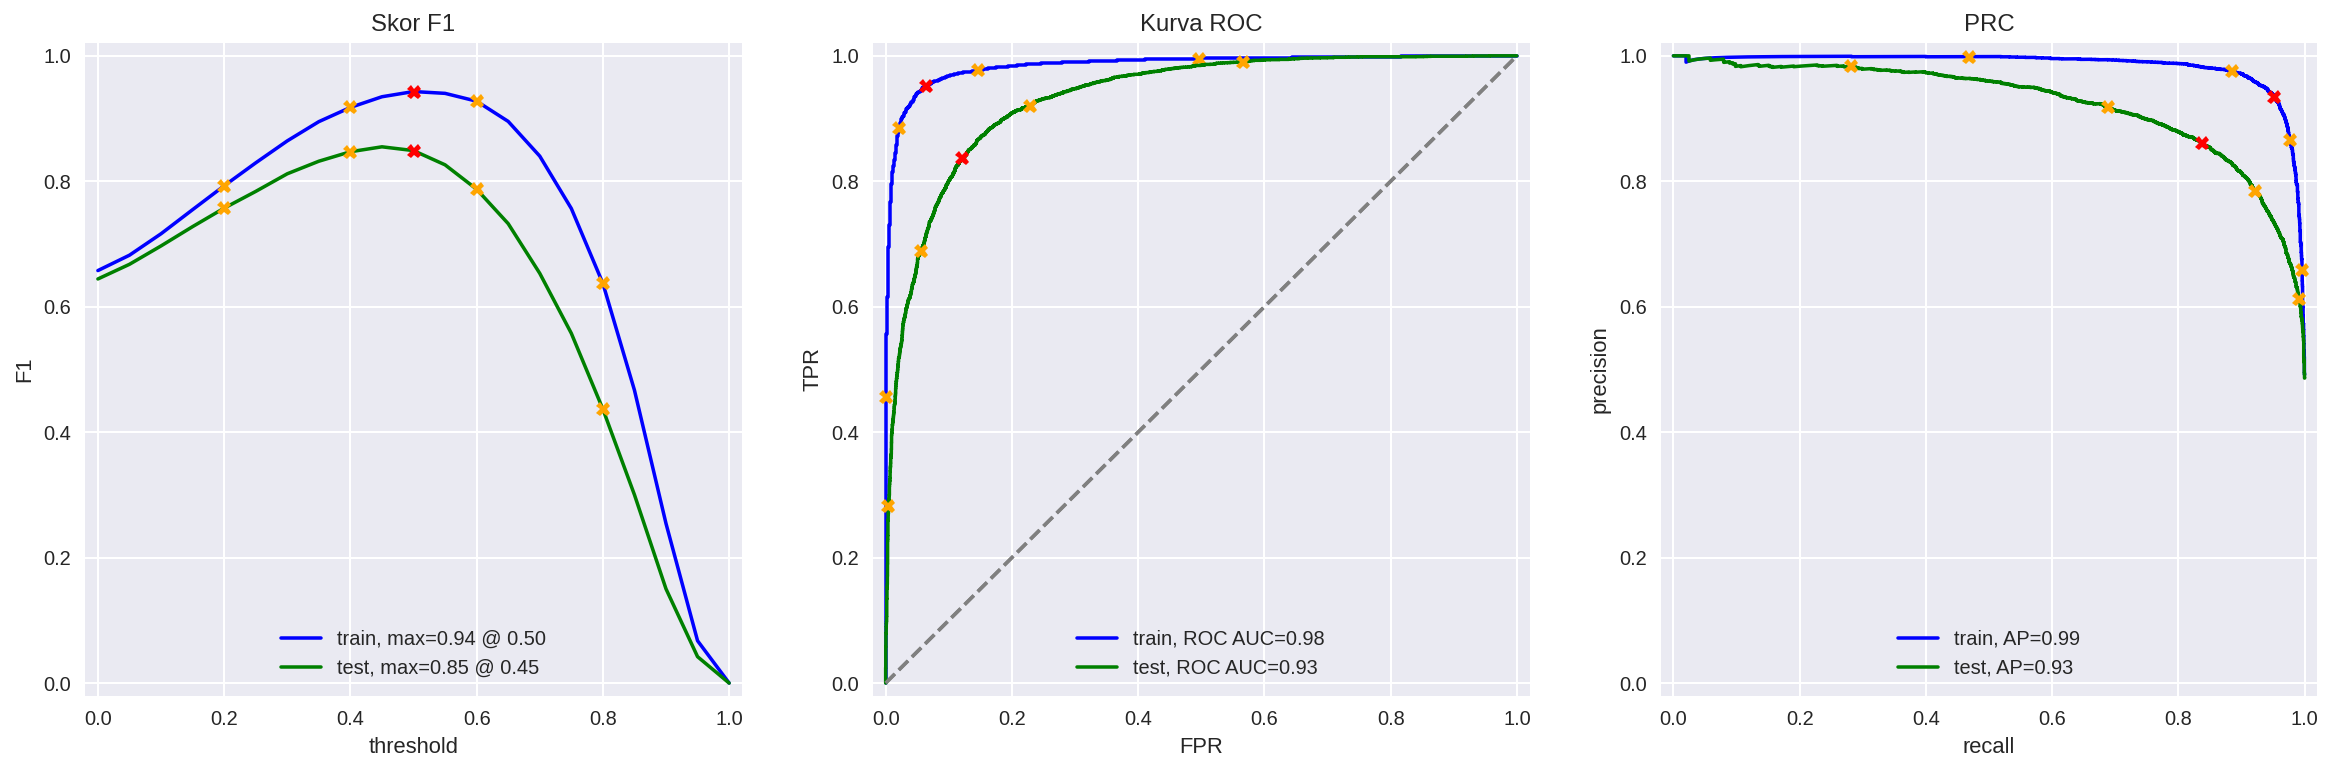

In [ ]:
evaluate_model(model_LR1, train_tfidf1, y_train[:10000], test_tfidf1, y_test[:10000])

In [ ]:
#Before Lemmatize
x_train['review_norm'].head(1).array

<PandasArray>
["the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but that's not what i got out of it i didn't get anything in the first half there's a new character without introduction in every other scene the first half hour is completely incomprehensible the rest is just one long annoying underlit chase scene there's always an irritating sound in the background whether it's a loud watch ticking a blaring siren a train whistling or even the horrible score by quincy jones there are a lot of parts that are laughably bad too like the bad guys chasing beatty on thin ice with a car or the police arriving at the scene roughly fifteen times i really hated this movie"]
Length: 1, dtype: object

In [ ]:
#After Lemmatize
lemma_train.head(1).array

<PandasArray>
['the pakage imply that warren beatty and goldie hawn be pull off a huge bank robbery but that be not what I get out of it I do not get anything in the first half there be a new character without introduction in every other scene the first half hour be completely incomprehensible the rest be just one long annoying underlit chase scene there be always an irritate sound in the background whether it be a loud watch tick a blaring siren a train whistle or even the horrible score by quincy jones there be a lot of part that be laughably bad too like the bad guy chase beatty on thin ice with a car or the police arrive at the scene roughly fifteen time I really hate this movie']
Length: 1, dtype: object

### Model 4 - spaCy, TF-IDF dan LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
%%time
model_LGBM =LGBMClassifier()
model_LGBM.fit(train_tfidf1, y_train[:10000])

CPU times: user 20.4 s, sys: 118 ms, total: 20.6 s
Wall time: 20.8 s


LGBMClassifier()

          train  test
Accuracy   0.95  0.85
F1         0.95  0.84
APS        0.99  0.91
ROC AUC    0.99  0.92


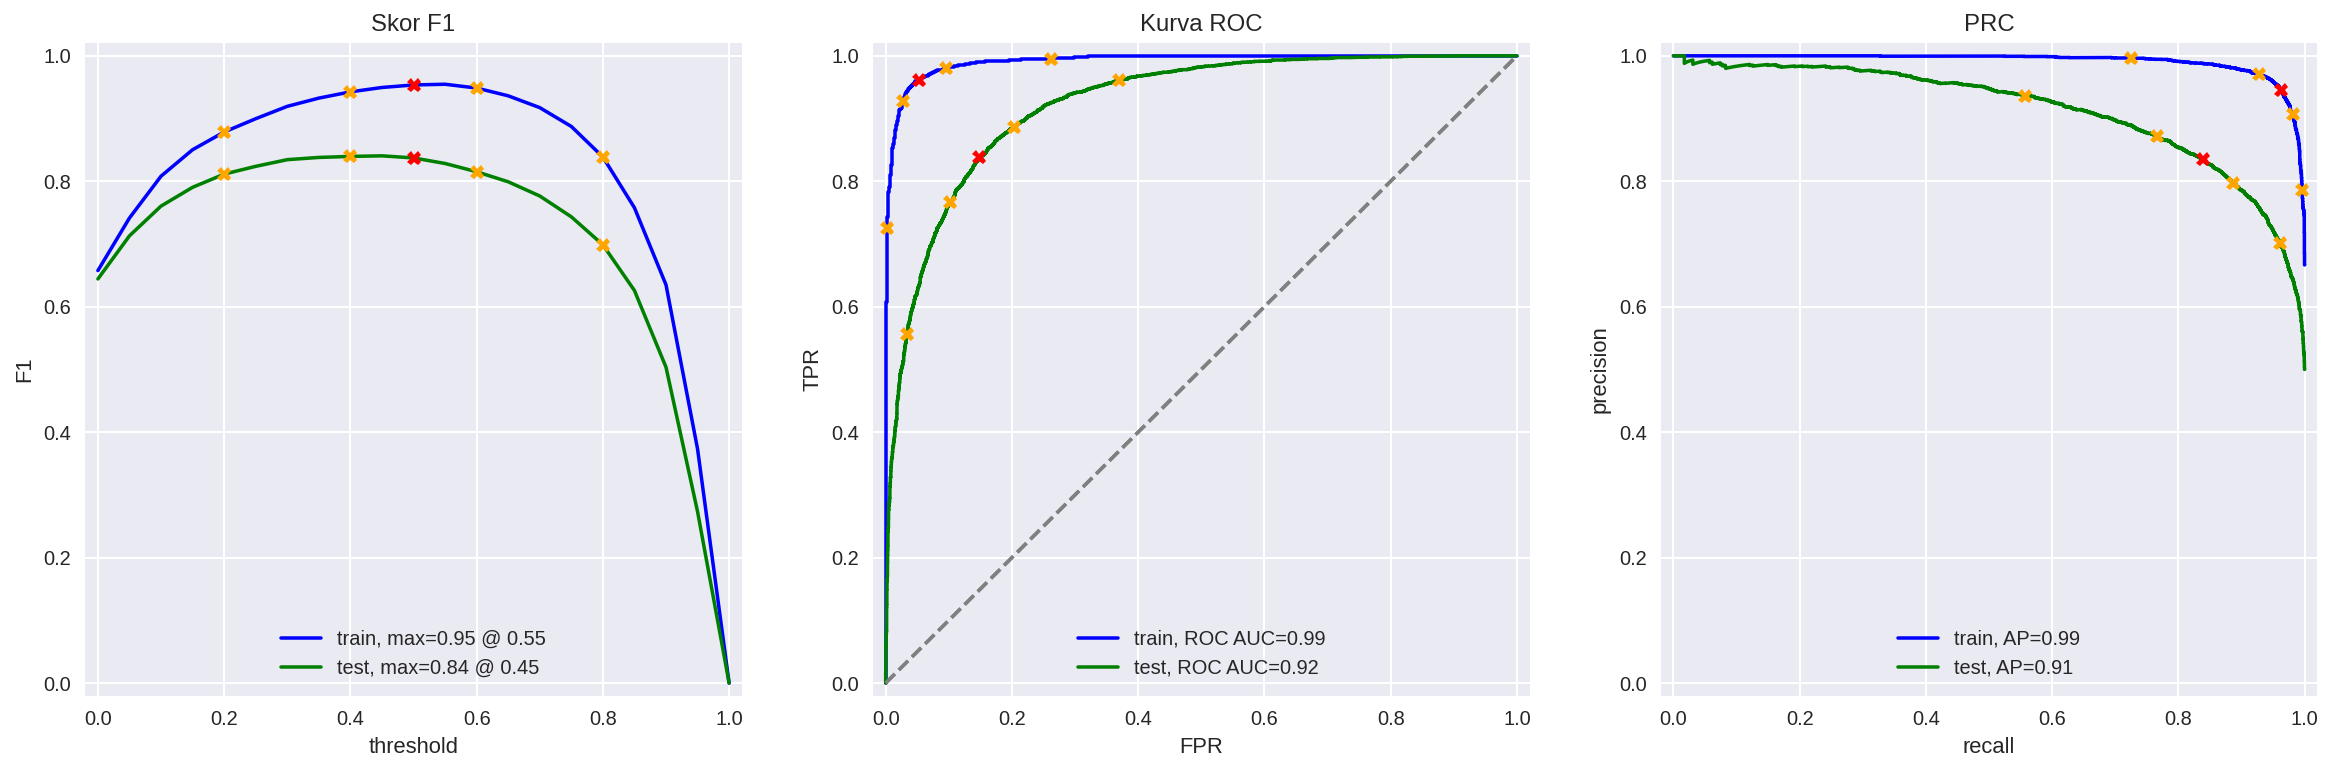

In [ ]:
evaluate_model(model_LGBM, train_tfidf1, y_train[:10000], test_tfidf1, y_test[:10000])

###  Model 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # teks ke id token yang sudah di-padded bersamaan dengan attention mask

    # <masukkan kode di sini untuk ids_list dan attention_mask_list>

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Gunakan {perangkat} perangkat.')

    # dapatkan embedding dalam batch

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <masukkan kode di sini untuk membuat attention_mask_batch

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# jika sudah mendapatkan embedding, disarankan untuk menyimpannya agar siap
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# dan muat...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Ulasan Saya

In [ ]:
# jangan ragu untuk menghapus ulasan ini dan mencoba model Anda sendiri terhadap ulasan Anda, ini hanyalah sekadar contoh

my_reviews = pd.DataFrame([
    "The Shape of Water is a visually stunning masterpiece that captivates from beginning to end. Guillermo del Toro's direction is impeccable, and the performances by Sally Hawkins and Doug Jones are extraordinary. The film beautifully combines fantasy, romance, and social commentary, creating a unique and magical experience. The cinematography and production design are breathtaking, and the musical score perfectly complements the story. This is a must-see film that pushes boundaries and leaves a lasting impact.",
    "Fantastic Four is a disappointing and poorly executed superhero film. The story lacks depth and coherence, leaving the audience disconnected and unengaged. The character development is weak, and the performances feel flat and uninspired. The visual effects are subpar, often looking artificial and unconvincing. The pacing is uneven, with a lack of tension or excitement throughout. Overall, it fails to capture the essence of the beloved comic book characters and falls short in delivering an entertaining and satisfying movie experience.",
    "La La Land is a delightful and enchanting musical that captures the magic of old Hollywood. The chemistry between Ryan Gosling and Emma Stone is undeniable, and their performances are truly captivating. The film is a love letter to dreamers and artists, with its beautiful cinematography and memorable musical numbers. The direction by Damien Chazelle is masterful, creating a perfect balance of romance, drama, and whimsy. The heartfelt story and the bittersweet ending leave a lasting impression. La La Land is a modern classic that reminds us of the power of following our dreams.",
    "The Last Airbender is a disappointing adaptation that fails to capture the essence and charm of the beloved animated series. The acting is wooden and lacks depth, with unconvincing performances throughout. The dialogue feels stilted and poorly written, leaving little room for character development. The visual effects are underwhelming, with CGI that appears cheap and poorly integrated. The plot is convoluted and rushed, failing to engage the audience or create any sense of excitement. Overall, The Last Airbender is a missed opportunity and a letdown for fans of the original series.",
    "Inception is a mind-bending masterpiece that keeps you on the edge of your seat from start to finish. Christopher Nolan's visionary direction, coupled with a stellar ensemble cast led by Leonardo DiCaprio, delivers a thrilling and thought-provoking cinematic experience. The intricate and complex plot is brilliantly executed, with seamless transitions between dream levels and layers of reality. The visual effects are groundbreaking, creating stunning and immersive dreamscapes. Hans Zimmer's haunting score adds another layer of intensity to the film. Inception is a true triumph of storytelling and filmmaking that leaves you questioning the nature of reality long after the credits roll.",
    "Transformers: Revenge of the Fallen is a chaotic and overly convoluted mess. The plot is nonsensical, with little regard for coherence or character development. The excessive use of CGI and explosions becomes tiresome and takes away from any semblance of a compelling story. The dialogue is riddled with cringe-worthy humor and lacks depth. The action sequences are visually impressive but lack substance and emotional investment. The film feels like a bloated spectacle without any real substance or purpose. Transformers: Revenge of the Fallen is a prime example of style over substance."
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)# <masukkan logika normalisasi yang sama di sini sebagaimana pada dataset utama>

my_reviews

,review,review_norm
0,The Shape of Water is a visually stunning mast...,the shape of water is a visually stunning mast...
1,Fantastic Four is a disappointing and poorly e...,fantastic four is a disappointing and poorly e...
2,La La Land is a delightful and enchanting musi...,la la land is a delightful and enchanting musi...
3,The Last Airbender is a disappointing adaptati...,the last airbender is a disappointing adaptati...
4,Inception is a mind-bending masterpiece that k...,inception is a mind bending masterpiece that k...
5,Transformers: Revenge of the Fallen is a chaot...,transformers revenge of the fallen is a chaoti...


### Model 2

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')

train_tfidf = tfidf.fit_transform(x_train['review_norm'])

test_tfidf = tfidf.transform(x_test['review_norm'])

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_LR.predict_proba(tfidf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.95:  the shape of water is a visually stunning masterpiece that captivates from beginning to end guillerm
0.06:  fantastic four is a disappointing and poorly executed superhero film the story lacks depth and coher
0.96:  la la land is a delightful and enchanting musical that captures the magic of old hollywood the chemi
0.01:  the last airbender is a disappointing adaptation that fails to capture the essence and charm of the 
0.94:  inception is a mind bending masterpiece that keeps you on the edge of your seat from start to finish
0.11:  transformers revenge of the fallen is a chaotic and overly convoluted mess the plot is nonsensical w


### Model 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_LR1.predict_proba(tfidf1.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.90:  the shape of water is a visually stunning masterpiece that captivates from beginning to end guillerm
0.10:  fantastic four is a disappointing and poorly executed superhero film the story lacks depth and coher
0.92:  la la land is a delightful and enchanting musical that captures the magic of old hollywood the chemi
0.05:  the last airbender is a disappointing adaptation that fails to capture the essence and charm of the 
0.81:  inception is a mind bending masterpiece that keeps you on the edge of your seat from start to finish
0.17:  transformers revenge of the fallen is a chaotic and overly convoluted mess the plot is nonsensical w


### Model 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf1
my_reviews_pred_prob = model_LGBM.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.98:  the shape of water is a visually stunning masterpiece that captivates from beginning to end guillerm
0.06:  fantastic four is a disappointing and poorly executed superhero film the story lacks depth and coher
0.97:  la la land is a delightful and enchanting musical that captures the magic of old hollywood the chemi
0.06:  the last airbender is a disappointing adaptation that fails to capture the essence and charm of the 
0.86:  inception is a mind bending masterpiece that keeps you on the edge of your seat from start to finish
0.22:  transformers revenge of the fallen is a chaotic and overly convoluted mess the plot is nonsensical w


### Model 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  saya tidak begitu menyukainya, bukan jenis film kesukaan saya
0.01:  membosankan, bahkan saya tidur di tengah film 
0.99:  filmnya sangat bagus, saya sangat suka 
0.00:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya, apakah mereka dibayar untuk bermain film 0.21:  saya tidak menyangka filmnya sebagus ini, penulisnya sangat memperhatikan detail 
0.94:  film ini memiliki kelebihan dan kekurangan, tetapi saya merasa secara keseluruhan ini adalah film yang layak 
0.09:  beberapa lawakannya sungguh tidak lucu aktornya menyebalkan 
0.96:  menampilkan film di Netflix adalah langkah yang berani, saya sangat menghargai bisa menonton episode demi episode 


## Kesimpulan

Datasets mempunyai target yang seimbang antara Ulasan Negatif dan Positif.

dilakukan Clear Text dimana Kolom Review/Ulasan diubah agar hanya menyisakan kata kata dan dibuat kolom baru yaitu kolom review_norm.

Lalu dilakukan Lemmatize/ perubahan bentuk kata menjadi kata awal.

Setelah Kolom Review sudah di clear text dan lemmatize. baru di lakukan pemodelan dengan 3 model Machine Learning Logistic Regression dan LGBMClassifier, untuk BERT dikarenakan device tidak mampu untuk menjalan kan nya. oleh karena itu akan saya coba sendiri di Google Colab.

**Ulasan Saya**

setelah menggunakan Ulasan yang lain dan dimasukan kedalam 3 Model Machine Learning yang telah di buat. didapat hasil yang sangat bagus, dimana Ulasan yang di berikan mendapatkan prediksi yang 100% benar.